# Advent of Code 2024

Advent of Code is a yearly celebration of coding challenges done every day leading up to Christmas. Each day has two, usually closely related, challenges for you to perform. If you are interested, you can follow the fun for the 2024 season at [adventofcode.com](https://www.adventofcode.com/2024).

## Frontmatter

This helps establish some basic functions we can reuse later on in this document.

In [1]:
def read_file_to_array(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

## Day 1: Historian Hysteria

It appears that the Chief **Christmas** Historian is missing, and the chief is known for always attending the sleigh launch. As such, we've taken it upon ourselves to go out there and figure out where they've gone.

### Part 1

In our search for historically significant locations, the elves have come up with two lists of locations (by a unique ID). However, the lists the elves come up with seem to be a little different, so we want to estimate the difference between the lists. This estimate is calculated by reading in the smallest number from each list and getting the difference, then doing the same for the second, third smallest and so on.

In [2]:
import re

lines = read_file_to_array('./data/1.txt')
# Use regex to capture the first and last numbers in each line
pattern = re.compile(r'(\d+)\s+(\d+)')
matches = [pattern.match(line).groups() for line in lines]

first_matches = [int(match[0]) for match in matches]
second_matches = [int(match[1]) for match in matches]

We now have the lists parsed, let's visualize the randomness of the lists first.

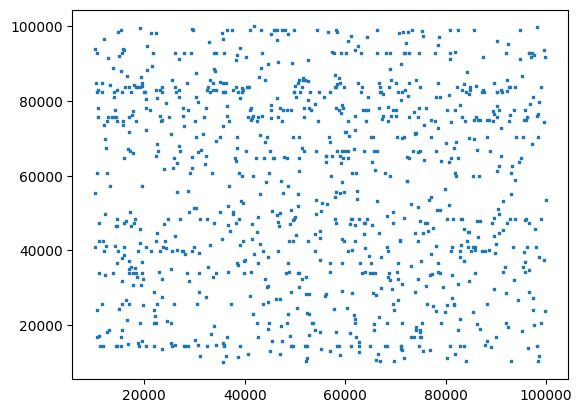

In [3]:
import matplotlib.pyplot as plt

def plot_scatter():
    _, ax = plt.subplots()
    ax.scatter(first_matches, second_matches, s = 1, marker = ',')
    plt.show()

plot_scatter()

Alright, the data's pretty random, next let's just sort the data and see if we can look at how much the data actually deviates.

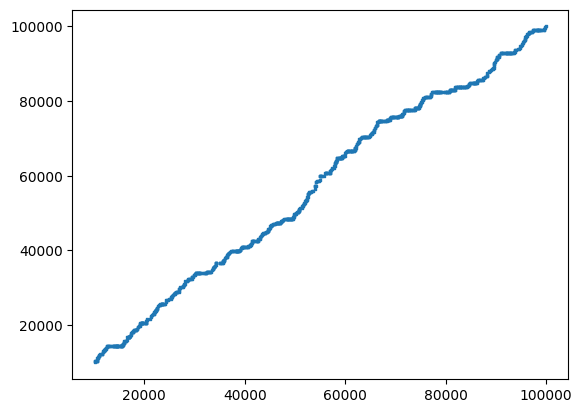

In [4]:
import matplotlib.pyplot as plt

first_matches.sort()
second_matches.sort()

plot_scatter()

The data's not too curved looking at it like this, but ultimately we're interested in the deviations here so let's calculate the difference and sum it up.

In [5]:
sum([abs(second_matches[i] - first_matches[i]) for i in range(len(first_matches))])

2430334

### Part 2

Now instead of estimating the differences between the two lists, we want to estimate the similarities of the two lists. This is computed by looping through the first list, and then multiplying it by the number of times the number appears in the second list, and finally adding them all together.

In [6]:
from collections import Counter

second_matches_count = dict(Counter(second_matches))
filtered_matches = [match for match in first_matches if match in second_matches_count]

Now that we have the count of second matches and the value of each valid first match, all that's left is to sum the values. We've plotted the similarities

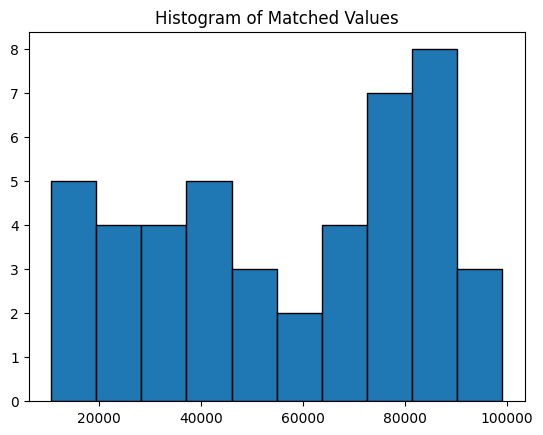

In [7]:
import matplotlib.pyplot as plt

plt.hist(filtered_matches, bins=10, edgecolor='black')
plt.title('Histogram of Matched Values')
plt.show()

You can see the rough count of matches, between 2 and 8 for every 10000 values, so it's not a large number. Last all we need to do is cross-calculate the values and sum them up to get our answer.

In [8]:
sum([match * second_matches_count[match] for match in filtered_matches])

28786472

## Day 2: Red-Nosed Reports

So, we've gathered a list of locations for where the Chief Historian might be at. We've wandered over to check the [Red-Nosed Reindeer nuclear fusion/fission plant](https://adventofcode.com/2015/day/19) (this is amazing world building, seriously) and while the elves are checking every corner of the building, we've been asked to help with determining, from a list of reports, which reports are 'safe' for the nuclear fusion/fission plant. I think we need to shut this facility down if I'm being honest.



### Part 1

We want to start with the number of reports that are 'safe'.

For each report, it is considered safe iff

* The levels are either all increasing or all decreasing.
* Any two adjacent levels differ by at least one and at most three.

In [9]:
lines = read_file_to_array('./data/2.txt')
reports_raw = [line.split(' ') for line in lines]
reports = [[int(value) for value in report_raw] for report_raw in reports_raw]

Next we need to define a basic function that will help us to parse through a report and tell us if the report is safe or not.

In [10]:
def is_report_safe(report):
    increasing = report[0] < report[1]
    for i in range(len(report) - 1):
        diff = report[i + 1] - report[i]
        if diff == 0:
            return False
        elif increasing and diff < 0:
            return False
        elif not increasing and diff > 0:
            return False
        if abs(diff) > 3:
            return False
    return True

safe_reports = [report for report in reports if is_report_safe(report)]
len(safe_reports)

524

### Part 2

Apparently we can tolerate up to one unsafe level shift per-report by removing it, so instead of returning on the first instance of unsafe instability, we return unsafe when no value can be removed to make the report safe. Since the reports are fairly short, we can heavy-hand this by removing each value one by one to confirm there is no possible level we can remove to make a report safe. Technically we'd only need to check faulty levels, but it's simpler to just loop through each possible level instead.

In [11]:
def tolerant_safe_check(report):
    if is_report_safe(report):
        return True
    for i in range(len(report)):
        if is_report_safe(report[:i] + report[i + 1:]):
            return True
    return False

tolerant_safe_reports = [report for report in reports if tolerant_safe_check(report)]
len(tolerant_safe_reports)

569

## Day 3: Mull It Over

No mas on the Chief Historian yet, so we've wandered over to the shop to see if we can find the chief there, only to find that their computers are on the fritz. The system appears to have corrupted memory and we need to sort out the correct instructions and then execute them.

> Warning: This day's data has a **bad design**, the source data is multiple lines, but you should only consider it as a single line by joining it all together

### Part 1

We're going to look through the memory for all instances of `mul(\d+,\d+)` to determine what values to multiply. There may be similar instructions, even including spaces and the like, and we want to ignore those (I'm betting 'for now' until we get to part 2). Then ultimately we want to find the resulting sum of the results of each multiply instruction.

In [57]:
corrupted_instructions = read_file_to_array('./data/3.txt')
corrupted_instructions = ''.join(corrupted_instructions) # join the data due to the bad formatting of the source file

The first part is pretty simple, we just run a regex with a couple of capture groups, convert the values, multiply them out, and then add them up. Very methodical.

In [58]:
def sum_instruction(instruction):
    pattern = re.compile(r'mul\((\d+),(\d+)\)')
    matches = pattern.findall(instruction)
    values = map(lambda match: int(match[0]) * int(match[1]), matches)
    return sum(values)

sum_instruction(corrupted_instructions)

189600467

### Part 2

Alright, so I wasn't too far off on my guess here. Apparently there are `do()` and `don't()` instructions here and anything after a `don't()` instruction should be removed, unless you run into a `do()` instruction first. We can handle this by stripping out text from the instructions via two regex commands (there might be a way to do it in one, not sure). _This is the part that tripped me up and realized that I needed to merge the data into a single line_

In [59]:
def trim_instruction(instruction):
    instruction = re.sub(r"don't\(\)(.+?)do\(\)", '', instruction)
    instruction = re.sub(r"don't\(\)(.+)$", '', instruction)
    return instruction

corrupted_instructions = trim_instruction(corrupted_instructions)
sum_instruction(corrupted_instructions)

107069718